In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
from random import shuffle
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
%matplotlib inline

In [43]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, Xception, InceptionV3, ResNet50
from keras import models, layers, optimizers, regularizers, callbacks
from sklearn.model_selection import train_test_split

In [4]:
train = pd.read_csv('/Users/skylark/Desktop/age detection/train/train.csv')
train.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [5]:
class_dict = {}
rev_class = {}
for i,type in enumerate(train.Class.unique()):
    class_dict[type] = i
    rev_class[i] = type

In [6]:
train['Class_id'] = train['Class'].map(lambda x: class_dict[x])

In [7]:
train.Class_id.value_counts()

0    10804
1     6706
2     2396
Name: Class_id, dtype: int64

In [8]:
train.shape

(19906, 3)

In [9]:
test = pd.read_csv('/Users/skylark/Desktop/age detection/test/test.csv')
test.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [10]:
train_path = '/Users/skylark/Desktop/age detection/train/Train'
test_path = '/Users/skylark/Desktop/age detection/test/Test'

In [11]:
train_data = []
for i in train.ID:
    train_data.append(image.img_to_array(image.load_img(os.path.join(train_path, i), target_size=(150,150,3))))
train_data = np.array(train_data)    

In [12]:
test_data = []
for i in test.ID:
    test_data.append(image.img_to_array(image.load_img(os.path.join(test_path, i), target_size=(150,150,3))))
test_data = np.array(test_data)    

In [13]:
train_data.shape

(19906, 150, 150, 3)

In [14]:
test_data.shape

(6636, 150, 150, 3)

In [15]:
train_x, test_x, train_y, test_y = train_test_split(train_data, train.Class_id, test_size=0.3, random_state=100)

In [16]:
len(train_x) - int(len(train_x)*0.3)

9754

In [17]:
datagen = ImageDataGenerator(rescale=1./255, rotation_range=90, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, shear_range=0.2, brightness_range=(0.5,1), horizontal_flip=True)
datagen_test = ImageDataGenerator(rescale=1./255)

In [18]:
train_gen = datagen.flow(train_x[:9754], train_y[:9754], batch_size=32)
val_gen = datagen.flow(train_x[9754:], train_y[9754:], batch_size=32)
test_gen = datagen.flow(test_x, test_y, batch_size=32)

### Models

#### Baseline

In [73]:
model = models.Sequential()

In [74]:
model.add(layers.Conv2D(32, 3, kernel_regularizer=regularizers.L1L2(l1 = 0.01, l2=0.01), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.L1L2(l1 = 0.01, l2=0.01)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.L1L2(l1 = 0.01, l2=0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L1L2(l1 = 0.01, l2=0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)      

In [167]:
call_backs = [callbacks.ModelCheckpoint(filepath='/Users/skylark/Desktop/age detection/model.h5'),
             callbacks.ReduceLROnPlateau(),
             callbacks.EarlyStopping(patience=10)]

In [75]:
model.compile(optimizer=optimizers.RMSprop(2e-4), loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=20, validation_data=val_gen, callbacks=call_backs, validation_steps=100)

Epoch 1/20
100/100 [==============================] - 191s 2s/step - loss: 73.4170 - acc: 0.4984 - val_loss: 19.7922 - val_acc: 0.5506
Epoch 2/20
100/100 [==============================] - 160s 2s/step - loss: 14.5039 - acc: 0.5369 - val_loss: 10.1442 - val_acc: 0.5480
Epoch 3/20
100/100 [==============================] - 133s 1s/step - loss: 7.9513 - acc: 0.5372 - val_loss: 6.7192 - val_acc: 0.5323
Epoch 4/20
100/100 [==============================] - 130s 1s/step - loss: 6.2386 - acc: 0.5495 - val_loss: 6.0907 - val_acc: 0.5609
Epoch 5/20
100/100 [==============================] - 152s 2s/step - loss: 5.9404 - acc: 0.5181 - val_loss: 5.9247 - val_acc: 0.5472
Epoch 6/20
100/100 [==============================] - 161s 2s/step - loss: 5.8602 - acc: 0.5394 - val_loss: 5.7878 - val_acc: 0.5480
Epoch 7/20
100/100 [==============================] - 138s 1s/step - loss: 5.8239 - acc: 0.5391 - val_loss: 5.7114 - val_acc: 0.5467
Epoch 8/20
100/100 [==============================] - 153s 2s/ste

In [76]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

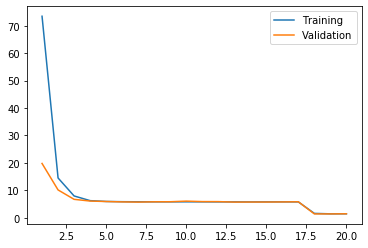

In [78]:
plt.plot(range(1, len(acc)+1), loss, label='Training')
plt.plot(range(1, len(acc)+1), val_loss, label='Validation')
plt.legend()
plt.show()

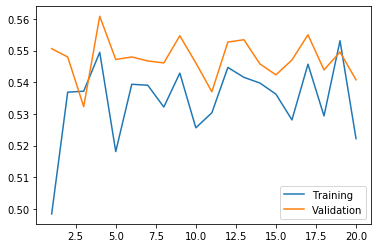

In [79]:
plt.plot(range(1, len(acc)+1), acc, label='Training')
plt.plot(range(1, len(acc)+1), val_acc, label='Validation')
plt.legend()
plt.show()

#### VGG16

In [44]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [45]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [46]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [47]:
model = models.Sequential()

In [48]:
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.1)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.1)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l=0.1)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(l=0.1)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)              

In [49]:
model.compile(optimizer=optimizers.RMSprop(2e-4), loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=50, validation_data=val_gen, callbacks=call_backs, validation_steps=100)

Epoch 1/50
100/100 [==============================] - 869s 9s/step - loss: 85.5943 - acc: 0.5085 - val_loss: 48.7216 - val_acc: 0.5481
Epoch 2/50
100/100 [==============================] - 863s 9s/step - loss: 30.1931 - acc: 0.5475 - val_loss: 16.5187 - val_acc: 0.5875
Epoch 3/50
100/100 [==============================] - 858s 9s/step - loss: 9.9127 - acc: 0.5578 - val_loss: 5.3005 - val_acc: 0.5800
Epoch 4/50
100/100 [==============================] - 894s 9s/step - loss: 3.4531 - acc: 0.5880 - val_loss: 2.1582 - val_acc: 0.6167
Epoch 5/50
100/100 [==============================] - 880s 9s/step - loss: 1.5940 - acc: 0.5894 - val_loss: 1.2796 - val_acc: 0.6128
Epoch 6/50
100/100 [==============================] - 980s 10s/step - loss: 1.0953 - acc: 0.5944 - val_loss: 0.9409 - val_acc: 0.6098
Epoch 7/50
100/100 [==============================] - 1057s 11s/step - loss: 0.9849 - acc: 0.5942 - val_loss: 0.9363 - val_acc: 0.6377
Epoch 8/50
100/100 [==============================] - 1138s 11

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

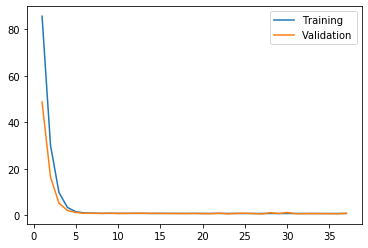

In [51]:
plt.plot(range(1, len(acc)+1), loss, label='Training')
plt.plot(range(1, len(acc)+1), val_loss, label='Validation')
plt.legend()
plt.show()

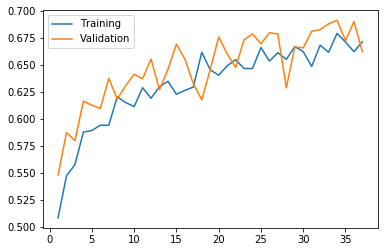

In [52]:
plt.plot(range(1, len(acc)+1), acc, label='Training')
plt.plot(range(1, len(acc)+1), val_acc, label='Validation')
plt.legend()
plt.show()

In [53]:
model.evaluate_generator(test_gen)

[0.9227460026741028, 0.6615874171257019]

In [216]:
pred = model.predict_classes(test_data/255)

In [217]:
test['class_type'] = pred

In [218]:
test['Class'] = test.class_type.map(lambda x: rev_class[x])

In [219]:
test.drop(['class_type'], axis=1).set_index('ID').to_csv('/Users/skylark/Desktop/age detection/result.csv')

### Inception

In [141]:
incep_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [143]:
incep_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [150]:
layers = []
for layer in incep_base.layers[-31:]:
    layers.append(layer.name)

In [151]:
layers

['conv2d_105',
 'batch_normalization_90',
 'activation_90',
 'conv2d_102',
 'conv2d_106',
 'batch_normalization_87',
 'batch_normalization_91',
 'activation_87',
 'activation_91',
 'conv2d_103',
 'conv2d_104',
 'conv2d_107',
 'conv2d_108',
 'average_pooling2d_9',
 'conv2d_101',
 'batch_normalization_88',
 'batch_normalization_89',
 'batch_normalization_92',
 'batch_normalization_93',
 'conv2d_109',
 'batch_normalization_86',
 'activation_88',
 'activation_89',
 'activation_92',
 'activation_93',
 'batch_normalization_94',
 'activation_86',
 'mixed9_1',
 'concatenate_2',
 'activation_94',
 'mixed10']

In [156]:
incep_base.trainable = True
set_trainable = False

for layer in incep_base.layers:
    if layer.name == 'conv2d_105':
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [180]:
model = models.Sequential()

In [181]:
model.add(incep_base)

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_16 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               2359424   
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)             

In [182]:
model.compile(optimizer=optimizers.RMSprop(2e-4), loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=10, validation_data=val_gen, callbacks=call_backs, validation_steps=100)

Epoch 1/10
100/100 [==============================] - 356s 4s/step - loss: 6.3203 - acc: 0.5569 - val_loss: 5.8561 - val_acc: 0.5663
Epoch 2/10
100/100 [==============================] - 317s 3s/step - loss: 4.4638 - acc: 0.6193 - val_loss: 7.4203 - val_acc: 0.4291
Epoch 3/10
100/100 [==============================] - 287s 3s/step - loss: 3.4524 - acc: 0.6266 - val_loss: 4.0925 - val_acc: 0.5285
Epoch 4/10
100/100 [==============================] - 283s 3s/step - loss: 2.7765 - acc: 0.6284 - val_loss: 2.6770 - val_acc: 0.5907
Epoch 5/10
100/100 [==============================] - 281s 3s/step - loss: 2.2623 - acc: 0.6419 - val_loss: 2.3768 - val_acc: 0.5225
Epoch 6/10
100/100 [==============================] - 270s 3s/step - loss: 1.9065 - acc: 0.6469 - val_loss: 3.8574 - val_acc: 0.4423
Epoch 7/10
100/100 [==============================] - 270s 3s/step - loss: 1.6816 - acc: 0.6274 - val_loss: 2.4249 - val_acc: 0.5750
Epoch 8/10
100/100 [==============================] - 271s 3s/step - 

In [183]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

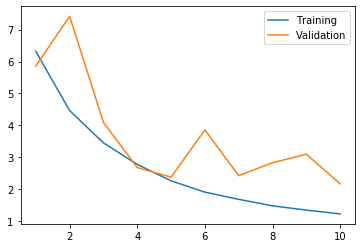

In [184]:
plt.plot(range(1, len(acc)+1), loss, label='Training')
plt.plot(range(1, len(acc)+1), val_loss, label='Validation')
plt.legend()
plt.show()

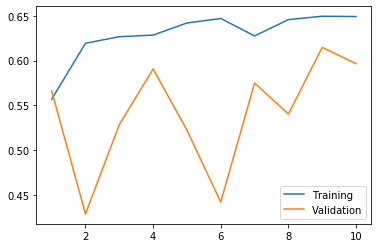

In [185]:
plt.plot(range(1, len(acc)+1), acc, label='Training')
plt.plot(range(1, len(acc)+1), val_acc, label='Validation')
plt.legend()
plt.show()

In [186]:
model.evaluate_generator(test_gen)

[2.220155715942383, 0.5914266705513]

### Xception

In [187]:
xcep_base = Xception(weights='imagenet', input_shape=(150, 150, 3), include_top=False)

In [189]:
xcep_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [191]:
xcep_base.layers[-26].name

'block12_sepconv1_act'

In [192]:
xcep_base.trainable = True
set_trainable = False

for layer in xcep_base.layers:
    if layer.name == 'block12_sepconv1_act':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [199]:
model = models.Sequential()

In [200]:
model.add(xcep_base)

model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_18 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 2048)              104859648 
_________________________________________________________________
dropout_29 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dropout_30 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 1024)            

In [201]:
model.compile(optimizer=optimizers.RMSprop(2e-4), loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=100, validation_data=val_gen, callbacks=call_backs, validation_steps=100)

Epoch 1/100
100/100 [==============================] - 1007s 10s/step - loss: 2159.3961 - acc: 0.4872 - val_loss: 681.5922 - val_acc: 0.5547
Epoch 2/100
100/100 [==============================] - 964s 10s/step - loss: 343.8104 - acc: 0.5303 - val_loss: 190.2930 - val_acc: 0.5430
Epoch 3/100
100/100 [==============================] - 973s 10s/step - loss: 160.6508 - acc: 0.5422 - val_loss: 139.4380 - val_acc: 0.5521
Epoch 4/100
100/100 [==============================] - 960s 10s/step - loss: 130.6639 - acc: 0.5338 - val_loss: 125.0386 - val_acc: 0.5405
Epoch 5/100
100/100 [==============================] - 891s 9s/step - loss: 122.3203 - acc: 0.5306 - val_loss: 120.6102 - val_acc: 0.5509
Epoch 6/100
100/100 [==============================] - 898s 9s/step - loss: 119.9115 - acc: 0.5466 - val_loss: 119.3298 - val_acc: 0.5508
Epoch 7/100
100/100 [==============================] - 988s 10s/step - loss: 119.1751 - acc: 0.5425 - val_loss: 119.1232 - val_acc: 0.5483
Epoch 8/100
100/100 [======

In [202]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

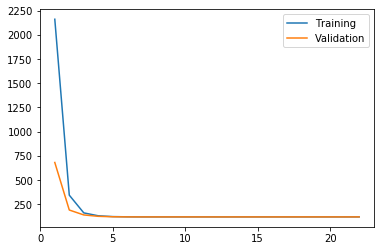

In [203]:
plt.plot(range(1, len(acc)+1), loss, label='Training')
plt.plot(range(1, len(acc)+1), val_loss, label='Validation')
plt.legend()
plt.show()

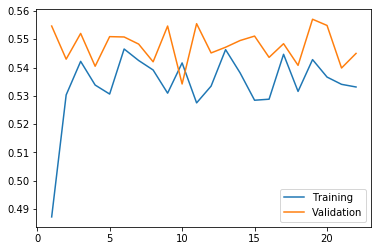

In [204]:
plt.plot(range(1, len(acc)+1), acc, label='Training')
plt.plot(range(1, len(acc)+1), val_acc, label='Validation')
plt.legend()
plt.show()

In [205]:
model.evaluate_generator(test_gen)

[119.11244201660156, 0.5493971705436707]

### ResNet50

In [23]:
res_conv = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

94658560/94653016 [==============================] - 110s 1us/step


In [24]:
res_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [27]:
res = res_conv.layers[-10].name

In [28]:
res_conv.trainable = True
set_trainable = False

for layer in res_conv.layers:
    if layer.name == res:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [37]:
model = models.Sequential()

In [38]:
model.add(res_conv)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)             

In [39]:
call_backs = [callbacks.ModelCheckpoint(filepath='/Users/skylark/Desktop/age detection/model.h5'),
             callbacks.ReduceLROnPlateau(),
             callbacks.EarlyStopping(patience=10)]

In [40]:
model.compile(optimizer=optimizers.RMSprop(2e-4), loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=100, validation_data=val_gen, callbacks=call_backs, validation_steps=100)

Epoch 1/100
100/100 [==============================] - 534s 5s/step - loss: 1.1757 - acc: 0.5576 - val_loss: 1.0493 - val_acc: 0.5503
Epoch 2/100
100/100 [==============================] - 516s 5s/step - loss: 0.9078 - acc: 0.6228 - val_loss: 1.0335 - val_acc: 0.5467
Epoch 3/100
100/100 [==============================] - 522s 5s/step - loss: 0.9266 - acc: 0.6003 - val_loss: 1.0705 - val_acc: 0.5402
Epoch 4/100
100/100 [==============================] - 607s 6s/step - loss: 0.8840 - acc: 0.6203 - val_loss: 1.0025 - val_acc: 0.5496
Epoch 5/100
100/100 [==============================] - 534s 5s/step - loss: 0.8919 - acc: 0.6252 - val_loss: 1.0347 - val_acc: 0.3334
Epoch 6/100
100/100 [==============================] - 525s 5s/step - loss: 0.8802 - acc: 0.6425 - val_loss: 1.0794 - val_acc: 0.3846
Epoch 7/100
100/100 [==============================] - 513s 5s/step - loss: 0.8526 - acc: 0.6547 - val_loss: 1.1173 - val_acc: 0.5433
Epoch 8/100
100/100 [==============================] - 507s 5s